In [96]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report, confusion_matrix

import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas


Importation of Dataset 2

In [97]:
# CHOOSE DATASET

# Binary classification dataset
diabetes =fetch_openml("diabetes", version = 1, as_frame=True)

X = diabetes.data.values
y = diabetes.target.values

y = np.where(y == "tested_positive", 1, 0)

print("Shape:", X.shape)

print(diabetes.data.head(), "\n \n")# first rows of features
print(diabetes.target.head()) # first rows of target

Shape: (768, 8)
   preg  plas  pres  skin  insu  mass   pedi  age
0     6   148    72    35     0  33.6  0.627   50
1     1    85    66    29     0  26.6  0.351   31
2     8   183    64     0     0  23.3  0.672   32
3     1    89    66    23    94  28.1  0.167   21
4     0   137    40    35   168  43.1  2.288   33 
 

0    tested_positive
1    tested_negative
2    tested_positive
3    tested_negative
4    tested_positive
Name: class, dtype: category
Categories (2, object): ['tested_negative', 'tested_positive']


In [98]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [99]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


In order to be able to compare the results, the number of clusters and value of m used, was the same as the one in the previous assigment ( n_clusters = 4; m=1.1)

In [100]:
 # Number of clusters 
n_clusters = 4
m=1.1

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [101]:
centers.shape

(4, 9)

In [102]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Fuzzy partition coefficient (FPC): 0.9091786112603655


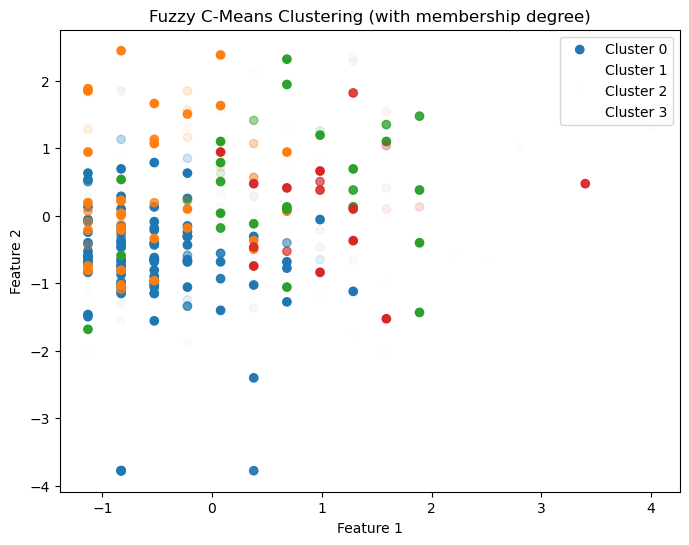

In [103]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

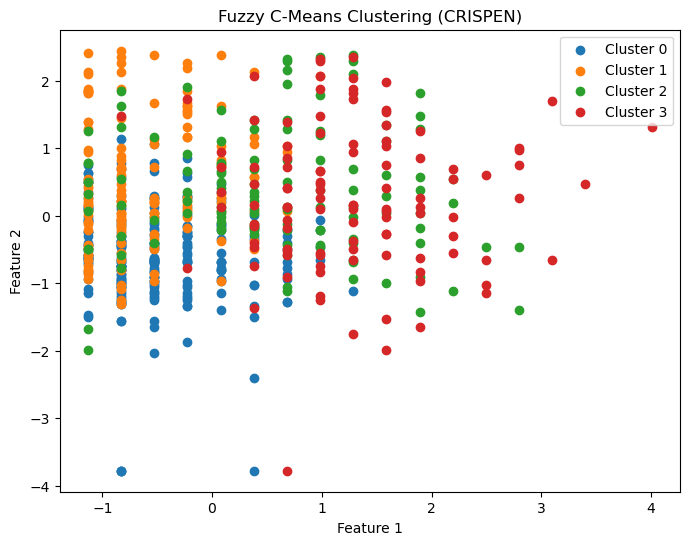

In [104]:
# Plot first two features with cluster assignments
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],
        Xexp[cluster_labels == j, 1],
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

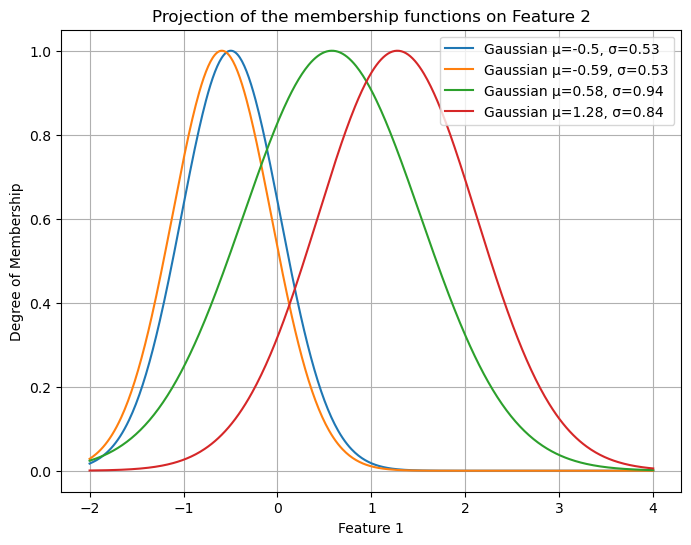

In [105]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
feature=0
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,feature], sigmas[j,feature]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,feature],2)}, σ={np.round(sigmas[j,feature],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

In [106]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



In [107]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

    


In [108]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        #print(loss)
        loss.backward()
        optimizer.step()


In [109]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3): #10, 20, 1e-3
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [110]:
# ---------------------------
# Alternative Hybrid Training (LS+ gradient descent on all)
# ---------------------------
def train_hybrid(model, X, y, epochs=100, lr=1e-5): #def; 100, 4
    # Step 1: LS for consequents
    train_ls(model, X, y)
    # Step 2: GD fine-tuning
    train_gd(model, X, y, epochs=epochs, lr=lr)


In [111]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


In [112]:
# Training with LS:
#train_ls(model, Xtr, ytr.reshape(-1,1))
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1), max_iters=13, gd_epochs=11, lr=1e-4) #10 20 3


In [113]:

thr = 0.6 #threshold to tune

y_pred, _, _=model(Xte)
y_true = yte.detach().numpy()
y_pred_bin = (y_pred.detach().numpy() > thr).astype(int)  # binary predictions

# Accuracy
acc = accuracy_score(y_true, y_pred_bin)
print(f'ACC:{accuracy_score(y_true,y_pred_bin)}') #classification

cm = confusion_matrix(y_true, y_pred_bin)
print("Confusion Matrix:")
print(cm)

#print(f'ACC:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

ACC:0.8116883116883117
Confusion Matrix:
[[93  6]
 [23 32]]


After manual tunning, the best model was achieved after changing the hyperparameters to: max_iters=13, gd_epochs=11, lr=1e-4. In comparison with TSK model previous used, it was possible to slightly improve the results, going from a accuracy score of 79.87% to 81.17%. The change was not significative, beeing able to only reduce 2 FP values (from 8 to 6). When visualizing the error (as ploted in the chart bellow) it is possible to notice that the model mutch better classifies for negative examples, represent by a clear separation in the predicted target distribution. To predict the positive exemples to model have more dificulty, presenting a recall score of 58.19% (TP/(TP+FN)).

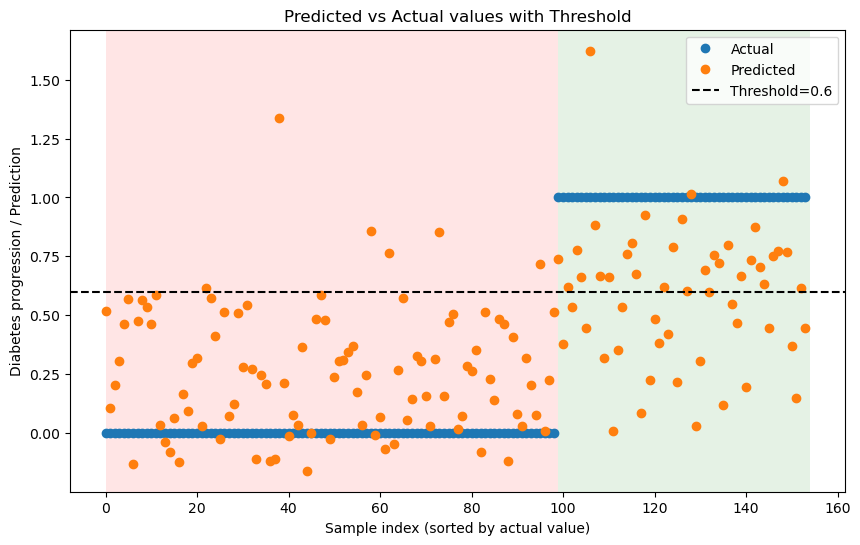

In [114]:
# Convert y_pred to numpy and flatten
y_pred_np = y_pred.detach().numpy().flatten()
y_pred_bin_np = y_pred_bin
yte_np = yte.detach().numpy()

# Get indices that sort yte
sort_idx = np.argsort(yte_np)

# Sort yte and y_pred
yte_sorted = yte_np[sort_idx]
y_pred_sorted = y_pred_np[sort_idx]

# Determine the index where actual target switches from 0 to 1
frontier_idx = np.argmax(yte_sorted == 1)  # first occurrence of 1

# Plot
plt.figure(figsize=(10,6))

# Shade negative region (yte = 0)
plt.axvspan(0, frontier_idx, facecolor='red', alpha=0.1)

# Shade positive region (yte = 1)
plt.axvspan(frontier_idx, len(yte_sorted), facecolor='green', alpha=0.1)

# Actual and predicted points
plt.plot(range(len(yte_sorted)), yte_sorted, label="Actual", marker="o", linestyle='')
plt.plot(range(len(y_pred_sorted)), y_pred_sorted, label="Predicted", marker="o", linestyle='')

# Threshold line
plt.axhline(y=thr, color='k', linestyle='--', label=f'Threshold={thr}')

plt.xlabel("Sample index (sorted by actual value)")
plt.ylabel("Diabetes progression / Prediction")
plt.title("Predicted vs Actual values with Threshold")
plt.legend()
plt.show()